In [1]:
import gc
import glob
import os
import time
import json

import coco
import viz
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from giss_data import GISSDetection, mAPevaluate

from coco import COCOMeta
from common import CustomResize, clip_boxes
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/w/anaconda3/envs/idp3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rcParams['figure.figsize'] = (16, 12)

In [3]:
GISS_classes = ['cars', 'small_trucks', 'truck',
                'building', 'person', 'container', 'misc']

color_dict = {'cars': 'r',
             'small_trucks': 'b',
             'truck': 'g',
             'building': 'c',
             'person': 'm',
             'container': 'y',
             'misc': 'k'}

class_dict = {'cars': 1,
             'small_trucks': 2,
             'truck': 3,
             'building': 4,
             'person': 5,
             'container': 6,
             'misc': 7}

class_dict = {v: k for k, v in class_dict.items()}

In [19]:
from matplotlib import patches


def get_center(x):
    x['x'] = x.xmax - x.xmin
    x['y'] = x.ymax - x.ymin
    return x


def show_bbs(y,
             image,
             image_name):

    y = y.apply(lambda x: get_center(x), axis=1)
    y_image = y[y.image_id == image_name]
    assert y_image.shape[0] > 0, 'No detections to show!'

    fig, ax = plt.subplots()
    ax.imshow(image)

    for i in range(y_image.shape[0]):
        plt_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
        color = color_dict[y_image.iloc[i, :]['category_id']]
        ax.add_patch(patches.Rectangle((y_image.iloc[i, :]['xmin'],
                                        y_image.iloc[i, :]['ymin']),
                                       y_image.iloc[i, :]['x'],
                                       y_image.iloc[i,
                                                    :]['y'], facecolor='none',
                                       edgecolor=color, lw=2))

    return


def load_eval_scores(preds_files):

    df_scores = []

    for i in preds_files:
        score_info = pd.read_json(i, typ='series')
        df_scores.append(score_info)

    df_scores = pd.DataFrame(df_scores)
    max_mAP = df_scores['mAP_valid'].max()

    print('Maximum mAP: {:.5f}'.format(max_mAP))

    return df_scores

### Preparation:

- in coco.py - COCODetection.load_many defines structure to load
- in data.py - get_train_dataflow() uses COCODetection to load and process data

### Evaluation:

In [42]:
data_src = '/home/w/projects/PW-GISS/data/data/giss_images/original/'

labels_src = '/home/w/projects/PW-GISS/data/models/labels/csv/labels_21_05_deg0/'
labels_files = sorted(glob.glob(labels_src + '*.csv'))

preds_src = 'train_log/maskrcnn/'
preds_files = sorted(glob.glob(preds_src + 'output/outputs*.json'))

scores_src = 'train_log/maskrcnn/'
scores_files = sorted(glob.glob(scores_src + 'mAP/mAP*.json'))

print('Prediction files:\n{}'.format(preds_files))

df_true_src = labels_files[0]
df_preds_src = preds_files[-1]

print(df_true_src)
print(df_preds_src)

Prediction files:
['train_log/maskrcnn/output/outputs_1036.json', 'train_log/maskrcnn/output/outputs_148.json', 'train_log/maskrcnn/output/outputs_296.json', 'train_log/maskrcnn/output/outputs_444.json', 'train_log/maskrcnn/output/outputs_592.json', 'train_log/maskrcnn/output/outputs_740.json', 'train_log/maskrcnn/output/outputs_888.json']
/home/w/projects/PW-GISS/data/models/labels/csv/labels_21_05_deg0/test_labels_21_05_deg0.csv
train_log/maskrcnn/output/outputs_888.json


In [43]:
df_scores = load_eval_scores(scores_files)

Maximum mAP: 0.13937


In [38]:
df_preds = pd.read_json(df_preds_src)
# df_preds.category_id = df_preds.category_id.map(class_dict)


df_preds['xmin'] = df_preds.bbox_raw.apply(lambda x: x[0])
df_preds['xmax'] = df_preds.bbox_raw.apply(lambda x: x[2])
df_preds['ymin'] = df_preds.bbox_raw.apply(lambda x: x[1])
df_preds['ymax'] = df_preds.bbox_raw.apply(lambda x: x[3])

# df_preds = df_preds[df_preds.score > 0.2].reset_index(drop=True)

len(df_preds)

2629

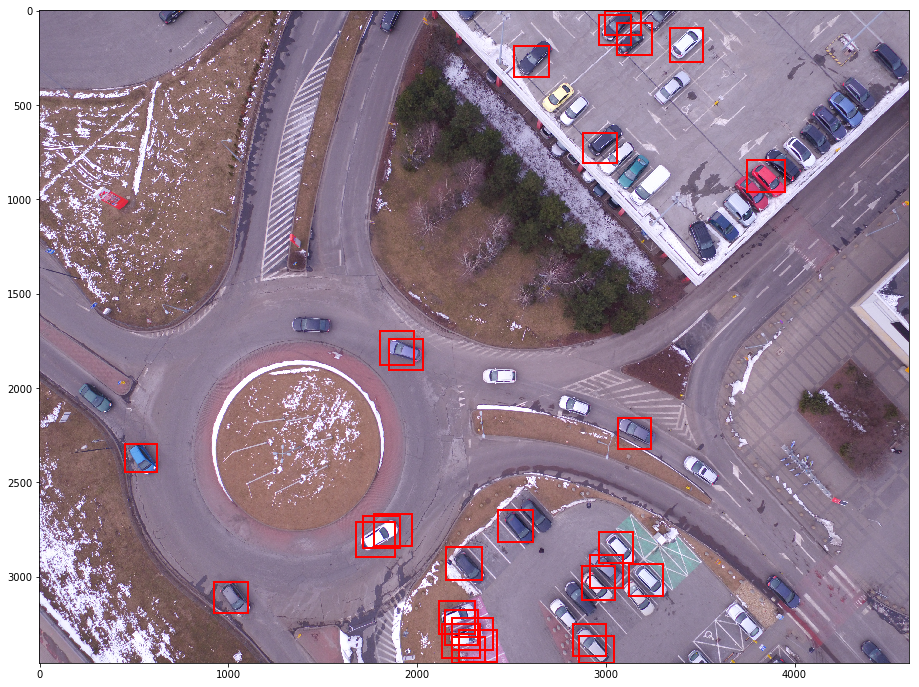

In [23]:
pred_index = np.random.randint(0, df_preds.shape[0])

img1 = cv2.imread(df_preds.loc[pred_index, 'image_id'])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

show_bbs(df_preds, img1, df_preds.loc[pred_index, 'image_id'])

In [ ]:
df_true = pd.read_csv(labels_files[2])
df_preds = pd.read_json(df_preds_src)

In [ ]:
map_eval = mAPevaluate(df_true_src, df_preds_src, data_src, iou_threshold=0.5)
valid_mAP, orig_missed_images = map_eval.compute_batch_ap()

### COCO debug: